In [1]:
import rescomp as rc
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7,7]

PRMS = {
    "res_sz": 1000,
    "activ_f": lambda x: 1/(1 + np.exp(-1*x)),
    "mean_degree": 2.0,
    "ridge_alpha": 1e-6,
    "spect_rad": 0.9,
    "gamma": 5.,
    "sigma": 0.14,
    "uniform_weights": True,
    "sparse_res": True,
    "signal_dim": 3
}

# A New Reservoir Computer Algorithm

### 1. Undriven reservoir computer

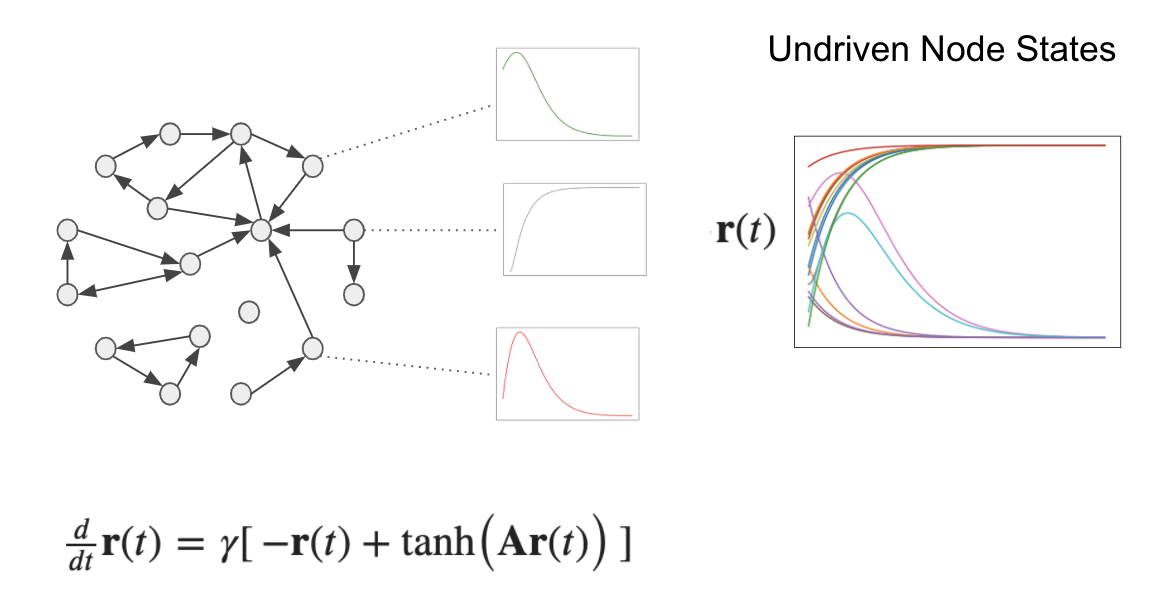

### 2. Driven Reservoir Computer

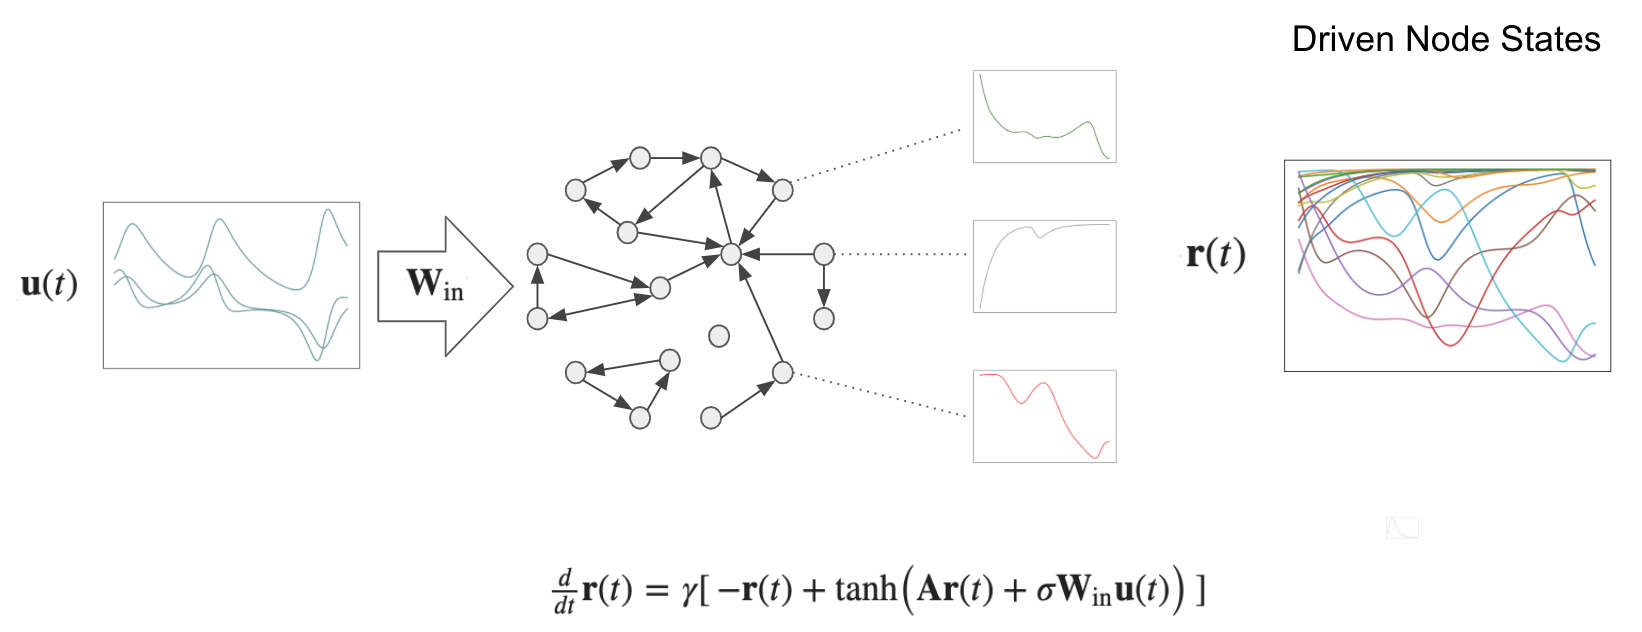

### 3. Map node states on to the driving signal

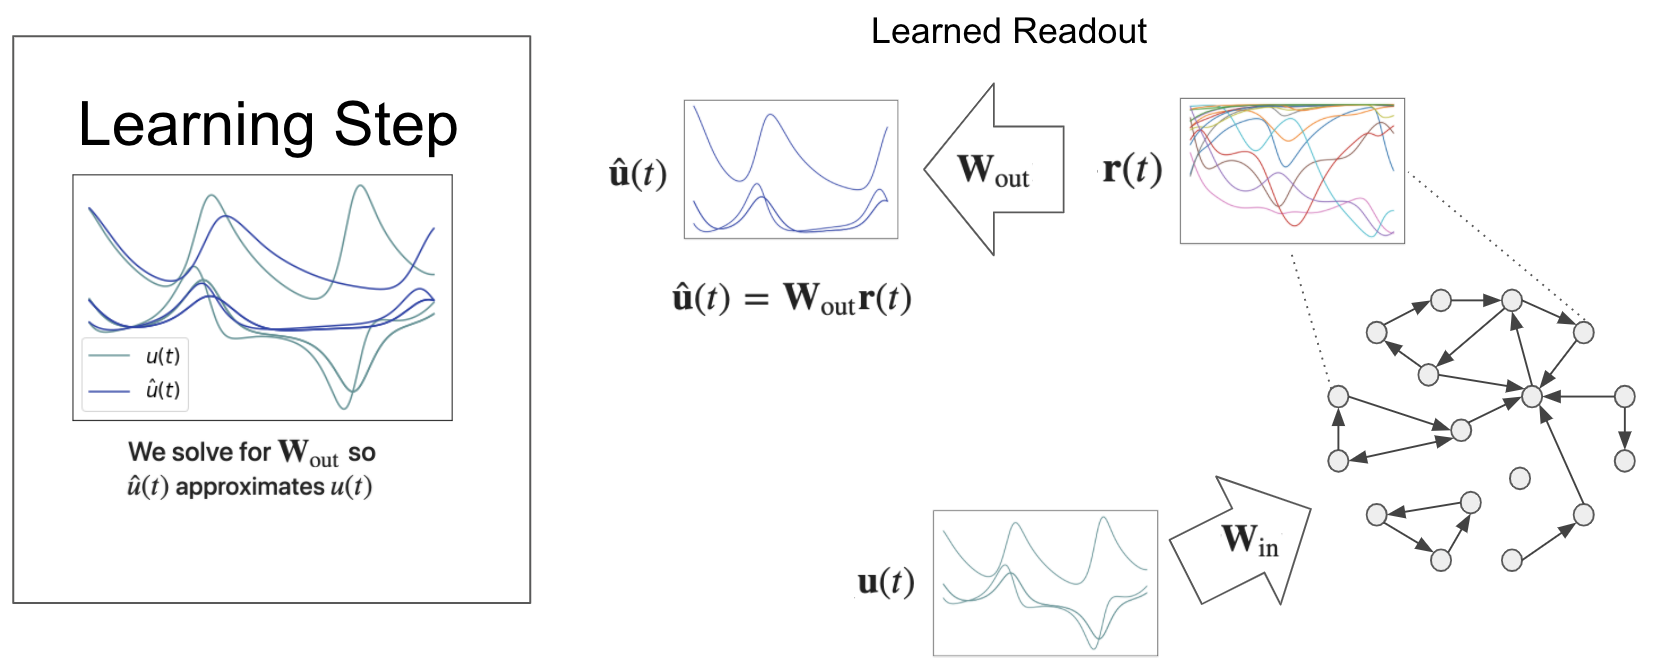

### 4. Stand-alone system

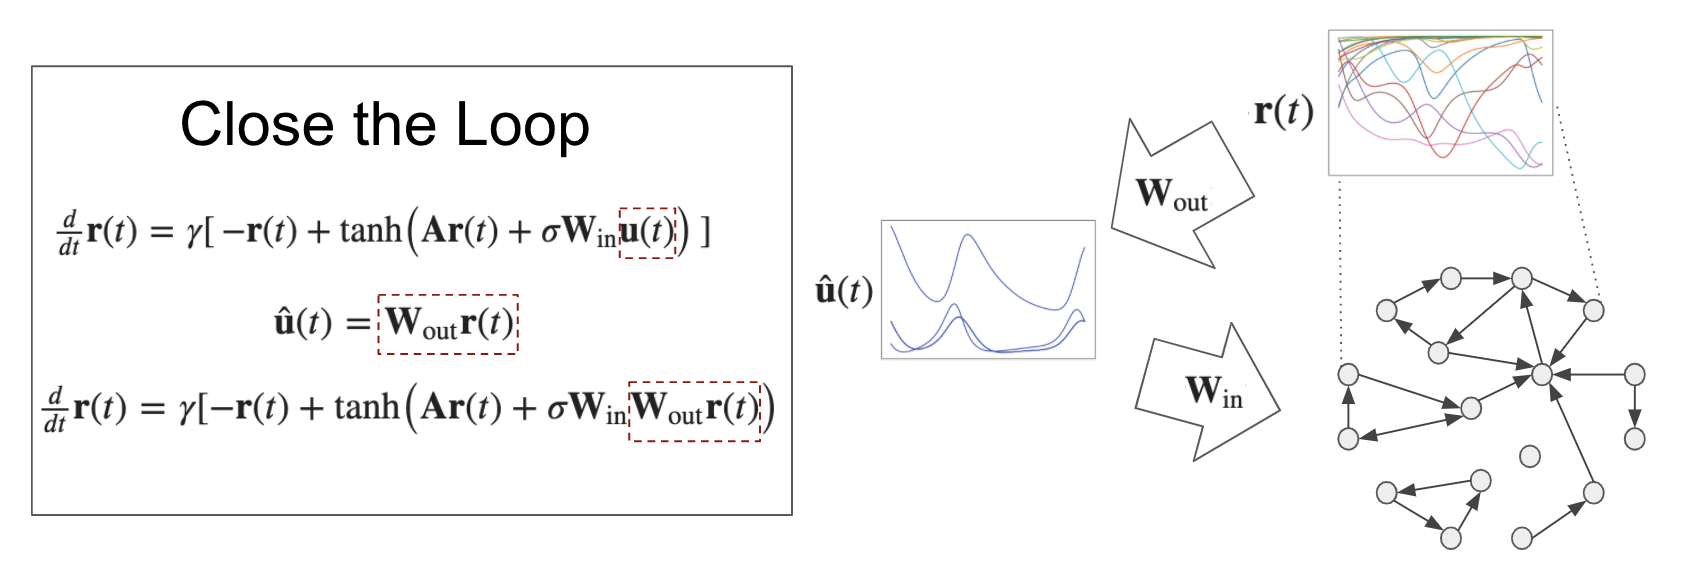

# Training Methods

![Algorithm Example](../../Latex/Images/algoexample.png)

# Examples

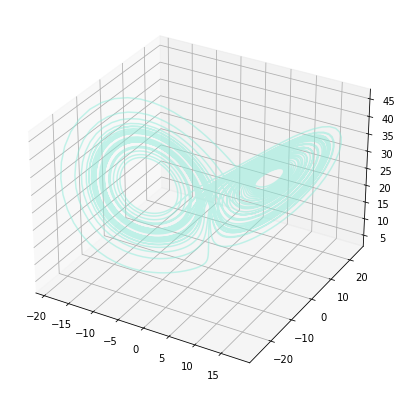

In [2]:
t, U = rc.orbit("lorenz", duration=50, trim=True)
col = rc.plot3d(U)

## Old Algorithm

In [3]:
# Train and test data
N = len(t)
mid = int(N//2)
ts, Uts = t[:mid], U[:mid, :]
tr, Utr = t[mid:], U[mid:, :]

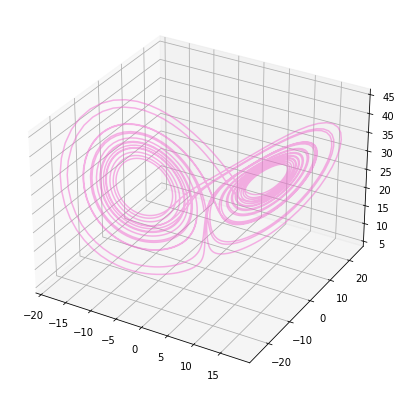

In [4]:
# Train the reservoir comp
rcomp = rc.ResComp(**PRMS)
rcomp.train(tr, Utr)

# Save the internal state
r0 = rcomp.r0

# Use it to predict
pre = rcomp.predict(ts, None, r0=r0)
col = rc.plot3d(pre)

This works, but the reservoir state after training is **not linked** to the state of the lorenz equations at the beginnng of the training orbit. Passing in the Lorenz equation initial condition at the start of the training data gives:

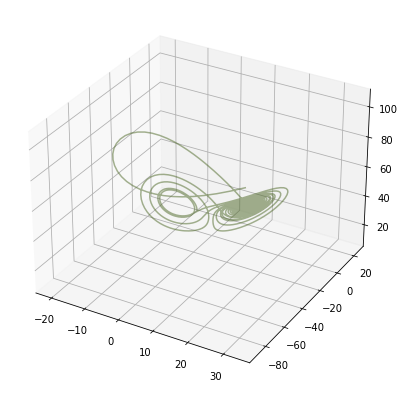

In [5]:
# Train the reservoir comp
rcomp = rc.ResComp(**PRMS)
rcomp.train(tr, Utr)
W = rcomp.W_out
# True initial condition
u0 = Uts[0, :]
# Use it to predict
pre = rcomp.predict(ts, u0)
col = rc.plot3d(pre)

Using the Pseudoinverse of $W_\text{out}$ to get a reservoir initial condition:

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


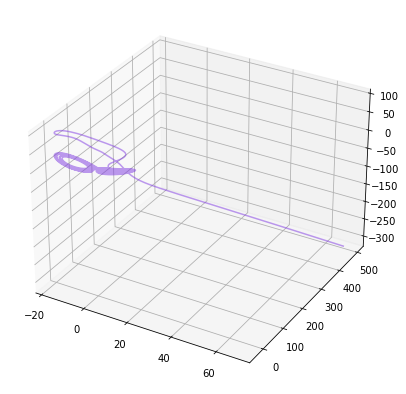

In [6]:
# Train the reservoir comp
rcomp = rc.ResComp(**PRMS)
rcomp.train(tr, Utr)
W = rcomp.W_out
# Pseudoinverse
W_out_inv = np.linalg.inv(W.T @ W) @ W.T
r0 = W_out_inv @ u0
# Use it to predict
pre = rcomp.predict(ts, None, r0=r0)
col = rc.plot3d(pre)

If you sample a random initial condition on the lorenz attractor, the result will be the same as above. However, if you perturb the original initial condition that the reservoir computer received, the reservoir gives a more accurate prediction:

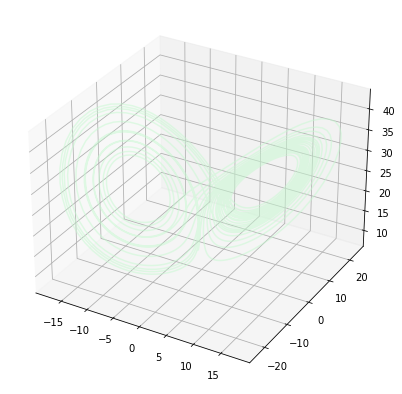

In [7]:
# Train the reservoir comp
rcomp = rc.ResComp(**PRMS)
rcomp.train(tr, Utr)

# Perturbed original initial condition
u0 = Utr[0, :] + np.random.randn(3)*1e-4

# Use it to predict
pre = rcomp.predict(ts, u0)
col = rc.plot3d(pre)

However, this predicition is essentially repeating the training data and therefore isn't very useful.

## New Algorithm

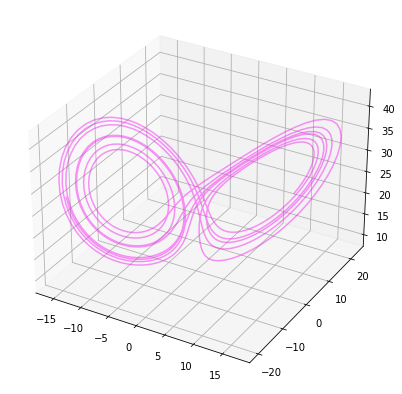

In [8]:
rcomp = rc.ResComp(**PRMS)
rcomp.train(tr, Utr, window=2, overlap=0.95)

# Note that this initial is not close to the original initial
# It also has no relation to the internal state
ts, Uts = rc.orbit("lorenz", duration=10, trim=True)

u0 = Uts[0, :]
pre = rcomp.predict(ts, u0)
col = rc.plot3d(pre)

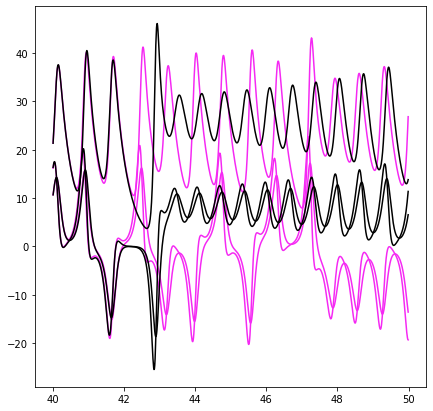

In [9]:
T = 1000
plt.plot(ts[:T], pre[:T], c=col)
plt.plot(ts[:T], Uts[:T], c="k")
plt.show()

In [10]:
def L2(x, axis=0):
    return np.sum(x**2, axis=axis)**0.5
def Linf(x, axis=0):
    return np.max(np.abs(x), axis=axis)

def relerr(true, pre, order=2, axis=0):
    if order == 2:
        norm = L2
    if order == "inf":
        norm = Linf
    return norm(true - pre) / norm(true)

def accduration(true, pre, tol, order="inf", axis=0):
    n = pre.shape[axis]
    for i in range(n):
        if axis == 0:
            t = true[i, :]
            p = pre[i, :]
        if axis == 1:
            t = true[:, i]
            p = pre[:, i]
        if relerr(t, p, order=order, axis=0) > tol:
            return i
    return n
    

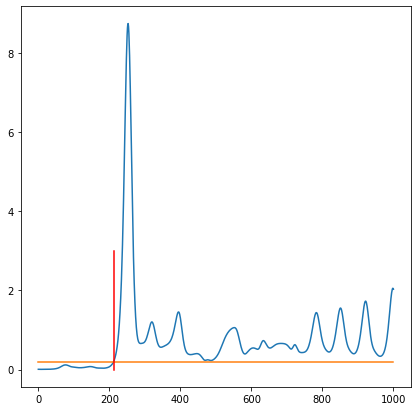

In [11]:
one = np.ones(pre.shape[0])
plt.plot(L2(pre - Uts, axis=1)/L2(Uts, axis=1))
plt.plot(0.2*one)
plt.plot(accduration(pre, Uts, 0.2)*one, np.linspace(0, 3, pre.shape[0]), c='r' )

In [12]:
accduration(pre, Uts, 1.0)

232

# Measuring Reconstruction

We have a system: 
$$ u' = F(t, u) $$

The reservoir computer prediction  $\hat{u}$, should  be a solution to the above equation. If it is a solution, 
$$
 \hat{u}' = F(t, \hat{u})
$$
We can estimate $\hat{u}'$ with a finite difference approximation and plug $t$ and $\hat{u}$ into $F$ to see if the finite difference matches the output of $F$. Thus we can measure the accuracy of our reservoir computer prediction with:
$$
|| \frac{\hat{u}(t+h) - \hat{u}(t-h)}{2h} - F(t, \hat{u}) ||
$$

# Measuring prediction time

In [ ]:
rcomp = rc.ResComp()